# Data Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filepath = '/content/drive/My Drive/AI Coursework/Biomarker_Clinical_Data_Images_2.csv'
Data = pd.read_csv(filepath)
Data.columns = Data.columns.str.strip()
Data.head()
disease_label_counts = Data['Disease Label'].value_counts()
print(disease_label_counts)
### Remember Class Imbalance ###

Disease Label
DME    112
DR      80
Name: count, dtype: int64


# Task 1: Supervised Machine Learning, Visualisation, and Feature Importance

## 1-1. Visualisation

   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

Text(0, 0.5, 'cumulative explained variance')

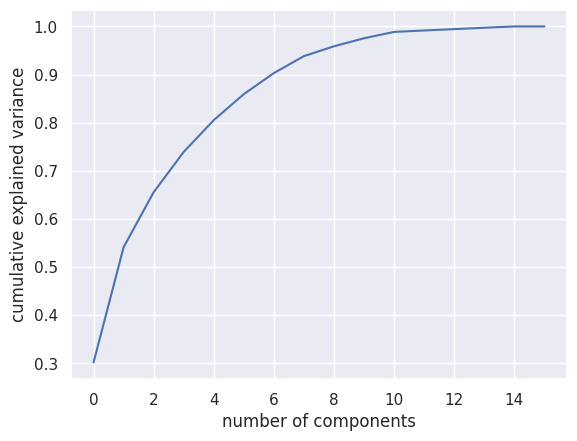

In [ ]:
VD = Data.iloc[:,1:17]
print(VD.head())
pca = PCA().fit(VD)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## 1-2. Selecting Models

### Only Biomarkers - SVM

In [4]:
### Only Biomarkers ###
# Feature selection (only Biomarkers) and target extraction
X = Data.drop(['Path', 'BCVA', 'CST', 'Disease Label', 'Eye_ID'], axis=1)  # Adjust column names if needed
Y = Data['Disease Label']
groups = Data['Eye_ID']

# Create GroupShuffleSplit instance
group_splitter = GroupShuffleSplit(test_size=0.25, random_state=42)

# Perform the split
train_idx, test_idx = next(group_splitter.split(X, Y, groups))

# Extract training and testing sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

# Manually apply stratification within each split to ensure balanced class distribution
def stratify_within_groups(X, Y, overall_distribution):
    """Stratifies the dataset within groups to match the overall class distribution."""
    stratified_X, stratified_Y = [], []

    for label, proportion in overall_distribution.items():
        # Subset data for the current label
        X_label = X[Y == label]
        Y_label = Y[Y == label]

        # Downsample to match the overall distribution
        n_samples = int(len(X) * proportion)
        downsampled_X, downsampled_Y = resample(
            X_label, Y_label,
            replace=False,
            n_samples=min(len(X_label), n_samples),
            random_state=42
        )
        stratified_X.append(downsampled_X)
        stratified_Y.append(downsampled_Y)

    return pd.concat(stratified_X), pd.concat(stratified_Y)

# Calculate overall class distribution
overall_distribution = Y.value_counts(normalize=True).to_dict()

# Apply stratification
X_train_stratified, Y_train_stratified = stratify_within_groups(X_train, Y_train, overall_distribution)
X_test_stratified, Y_test_stratified = stratify_within_groups(X_test, Y_test, overall_distribution)

X_train, Y_train = X_train_stratified, Y_train_stratified
X_test, Y_test = X_test_stratified, Y_test_stratified


## Verify the splitting integrity (each Eye_ID should be in only one of the splits)
train_eye_ids = set(Data["Eye_ID"].iloc[train_idx])
test_eye_ids = set(Data["Eye_ID"].iloc[test_idx])
overlap = train_eye_ids.intersection(test_eye_ids)

## Outputs for verification
print("Training set shape:", X_train_stratified.shape)
print("Testing set shape:", X_test_stratified.shape)
print("Overlap in Eye_ID between training and testing sets:", len(overlap))
print("Training set class distribution:\n", Y_train_stratified.value_counts(normalize=True))
print("Testing set class distribution:\n", Y_test_stratified.value_counts(normalize=True))








Training set shape: (144, 16)
Testing set shape: (48, 16)
Overlap in Eye_ID between training and testing sets: 0
Training set class distribution:
 Disease Label
DME    0.583333
DR     0.416667
Name: proportion, dtype: float64
Testing set class distribution:
 Disease Label
DME    0.583333
DR     0.416667
Name: proportion, dtype: float64


In [ ]:
# List of kernel options
kernels = ('linear', 'poly', 'rbf', 'sigmoid')

# Iterate through kernels
for kernel in kernels:
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=1, random_state=42)
    elif kernel == 'rbf':
        svm = SVC(kernel=kernel, gamma=1, C=0.7, random_state=42)
    else:
        svm = SVC(kernel=kernel, random_state=42)

    # Fit the model
    svm.fit(X_train, Y_train)

    # Make predictions
    Y_pred = svm.predict(X_test)

    # Generate the classification report
    report = classification_report(Y_test, Y_pred, target_names=Y_test.unique().astype(str).tolist())
    print(f"Classification Report for kernel={kernel}:\n{report}")


Classification Report for kernel=linear:
              precision    recall  f1-score   support

         DME       0.88      0.79      0.83        28
          DR       0.74      0.85      0.79        20

    accuracy                           0.81        48
   macro avg       0.81      0.82      0.81        48
weighted avg       0.82      0.81      0.81        48

Classification Report for kernel=poly:
              precision    recall  f1-score   support

         DME       0.88      0.79      0.83        28
          DR       0.74      0.85      0.79        20

    accuracy                           0.81        48
   macro avg       0.81      0.82      0.81        48
weighted avg       0.82      0.81      0.81        48

Classification Report for kernel=rbf:
              precision    recall  f1-score   support

         DME       0.85      0.79      0.81        28
          DR       0.73      0.80      0.76        20

    accuracy                           0.79        48
   macro a

In [ ]:
def gridsearch_kernel_optimisation(X_train, Y_train, X_test, Y_test, kernel, param_grid, scoring='f1_macro'):
    """
    Optimises parameters for a specific SVM kernel using GridSearchCV.

    Parameters:
        X_train, Y_train: Training data and labels.
        X_test, Y_test: Testing data and labels.
        kernel (str): The kernel name ('linear', 'poly', 'rbf', 'sigmoid').
        param_grid (dict): Dictionary of parameters to test for the kernel.
        scoring (str): Scoring metric for GridSearchCV ('accuracy', 'f1_macro', etc.).

    Returns:
        best_params (dict): The best parameters found by GridSearchCV.
    """
    # Add kernel to all parameter sets in the grid
    param_grid = [{'kernel': [kernel], **params} for params in param_grid]

    # Initialize the SVM model
    svm = SVC(random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring=scoring, cv=5, verbose=0)
    grid_search.fit(X_train, Y_train)

    # Display the best parameters
    best_params = grid_search.best_params_
    print(f"Best Parameters for kernel={kernel}: {best_params}")
    print(f"Best Cross-Validation Score: {grid_search.best_score_}\n")

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test)
    report = classification_report(Y_test, Y_pred, target_names=Y_test.unique().astype(str).tolist())
    print(f"Classification Report for the best model:\n{report}")

    return best_params, report

# Example usage for 'rbf' kernel
param_grid_rbf = [
    {'C': [0.42500000000000004], 'gamma': np.linspace(0.4,1,25)}
]

best_params_rbf, report_rbf = gridsearch_kernel_optimisation(
    X_train, Y_train, X_test, Y_test, kernel='rbf', param_grid=param_grid_rbf, scoring='f1_macro'
)

Best Parameters for kernel=rbf: {'C': 0.42500000000000004, 'gamma': 0.4, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8120851853032913

Classification Report for the best model:
              precision    recall  f1-score   support

         DME       0.84      0.75      0.79        28
          DR       0.70      0.80      0.74        20

    accuracy                           0.77        48
   macro avg       0.77      0.78      0.77        48
weighted avg       0.78      0.77      0.77        48



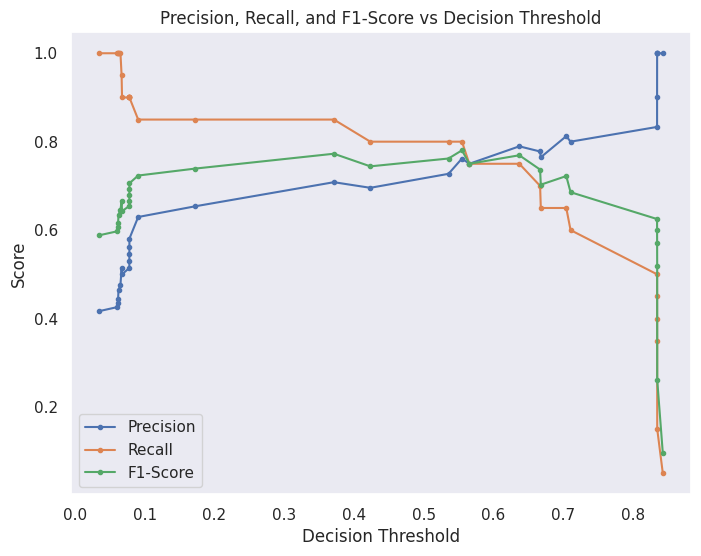

Optimal Threshold: 0.555044291604053
Optimal F1-Score: 0.7804878048780488
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         DME       0.85      0.82      0.84        28
          DR       0.76      0.80      0.78        20

    accuracy                           0.81        48
   macro avg       0.81      0.81      0.81        48
weighted avg       0.81      0.81      0.81        48



In [9]:
# Step 1: Train the model and get predicted probabilities
model = SVC(probability=True, C=0.42500000000000004, gamma=0.4, random_state=42)
model.fit(X_train, Y_train)

# Get predicted probabilities for the positive class (DR)
y_scores = model.predict_proba(X_test)[:, 1]  # Positive class probabilities

# Step 2: Calculate Precision-Recall values
precision, recall, thresholds = precision_recall_curve(Y_test, y_scores, pos_label='DR')

# Step 3: Calculate F1-scores for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])  # Exclude last point
f1_scores = np.nan_to_num(f1_scores)  # Handle NaN values (if precision + recall = 0)

# Step 4: Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", marker=".")
plt.plot(thresholds, recall[:-1], label="Recall", marker=".")
plt.plot(thresholds, f1_scores, label="F1-Score", marker=".")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Decision Threshold")
plt.legend()
plt.grid()
plt.show()

# Step 5: Find the optimal threshold (maximizing F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Optimal F1-Score: {f1_scores[optimal_idx]}")

# Step 6: Evaluate model at the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)  # Convert probabilities to binary predictions
y_pred_optimal = ['DR' if pred == 1 else 'DME' for pred in y_pred_optimal]  # Map to original labels

# Print the classification report
print("Classification Report at Optimal Threshold:")
print(classification_report(Y_test, y_pred_optimal, target_names=["DME", "DR"]))


### Only Clinical Labels - SVM

In [ ]:
X = Data[['BCVA','CST']]
Y = Data['Disease Label']
groups = Data['Eye_ID']
group_splitter = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(group_splitter.split(X, Y, groups))

### Combined - SVM

In [ ]:
X = Data.iloc[:,list(range(1,17)) + list(range(18,20))]
print(X.head())
Y = Data['Disease Label']
groups = Data['Eye_ID']
group_splitter = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(group_splitter.split(X, Y, groups))


   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

### Neural Network

## 1-3. Model Comparison

## 1-4. Evaluation of Feature Importance

# Task 2: Convolutional Neural Network (CNN) for Disease Classification and Data Augmentation




## 2-1. Network Design and Hyperparameter Optimization

## 2-2. Data Augmentation

## 2-3. Performance Analysis and Metrics

## 2-4. Fine-Tuning with Pre-trained Model


# Task 3: Integrating Clinical Labels, Biomarkers, and OCT Images

## 3-1. Feature Fusion with CNN


## 3-2. Ensemble Learning: